<a href="https://colab.research.google.com/github/YuvalShaffir/Makemore-LLM-/blob/main/makemore_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/intro_to_nn/makemore/names.txt'
with open(filepath, 'r') as f:
    words = f.read().splitlines()

Mounted at /content/drive


In [15]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [150]:
block_size = 3

In [95]:
def build_dataset(words):
  X, Y = [], []

  for w in words:
    # print(w)
    context = [0] * block_size  # Start with zero tokens. example in this case : '...'
    for ch in w + '.':  # Iterate over all chars of a word
      ix = stoi[ch]  # char to index
      X.append(context) # add context window
      Y.append(ix)  # add index of the current char
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]  # Rolling window of context

  X = torch.tensor(X) # Contexts
  Y = torch.tensor(Y) # Targets
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# The lookup table C is used to embed the 27 chars (27 dimensional space) into 2 dimensional space

In [130]:
g = torch.Generator().manual_seed(214783647)  # Generator with seed
C = torch.randn((27, 10), generator=g)  # Look-up table (each one of the 27 chars will have 2 embedings)
W1 = torch.randn((30, 200), generator=g)  # First layer weights
b1 = torch.randn(200, generator=g)  # First layer biases
W2 = torch.randn((200, 27), generator=g)  # Second layer wieghts
b2 = torch.randn(27, generator=g)  # Second layer biases
parameters = [C, W1, b1, W2, b2]

In [131]:
sum(p.nelement() for p in parameters)  # Number of parameters

11897

In [132]:
for p in parameters:
  p.requires_grad = True

In [108]:
# Learning rates
lre = torch.linspace(-3, 0, 30000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010,  ..., 0.9995, 0.9998, 1.0000])

In [133]:
lri = []
lossi = []
steps = []

In [146]:

for i in range(200000):
  # mini batch
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # Forward pass
  emb = C[Xtr[ix]]  # shape = (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
  logits = h @ W2 + b2  # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  steps.append(i)
  lossi.append(loss.log10().item())

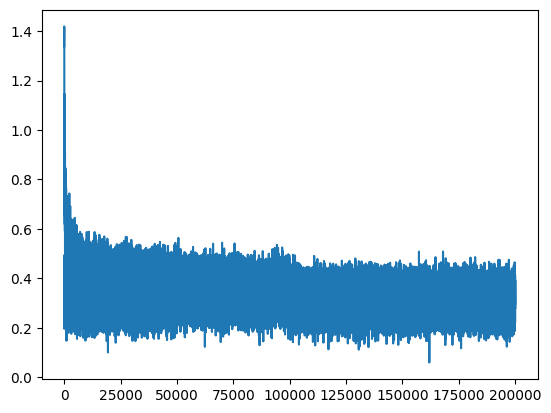

In [147]:
plt.plot(steps, lossi)

In [148]:
emb = C[Xtr]  # shape = (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.096392869949341


In [149]:
emb = C[Xdev]  # shape = (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.154737949371338


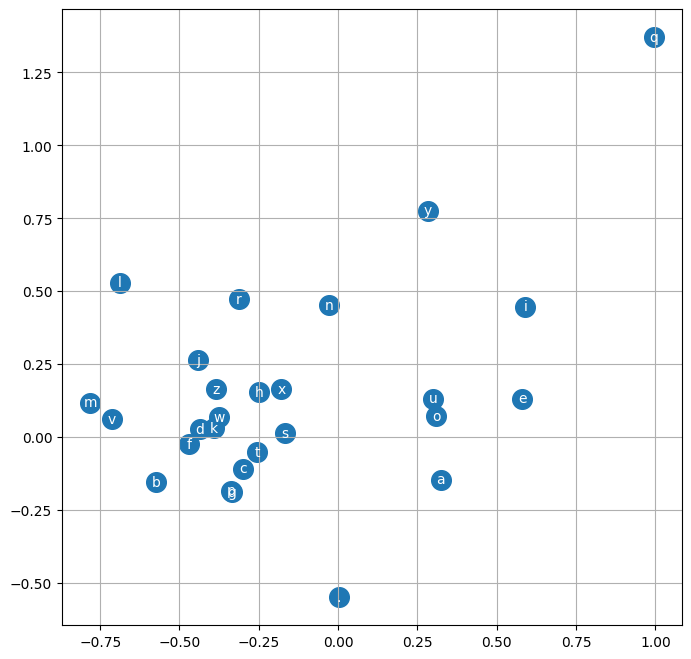

In [129]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [152]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

mona.
kayah.
see.
mad.
rylle.
emmad.
endra.
graderroselin.
shy.
jenne.
eliean.
nar.
katzion.
karin.
shruvi.
shiriel.
kin.
rendy.
panthona.
ubakard.
